# Anisotropy Analysis of Askja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import xarray as xr
# import pygmt
import pandas as pd
import json
import os
from tqdm import tqdm
import scipy
from scipy.optimize import curve_fit
import pickle
import sys
from importlib import reload
import glob
import math
from multiprocessing import Pool
sys.path.append("/space/jwf39/AnisotroPy/anisotropy")
sys.path.append("/space/jwf39/AnisotroPy")    

In [2]:
import anisotropy
import materials
import effective_modelling
from effective_modelling import tandon_weng, hudson

# Modeling of crack density using Hudson's model

In [118]:
vs_2km_avg = 2.6620920228078906 
vs_2km_std = 0.04508785791070994
pctani_2km_avg = -6.177631919552602 
pctani_2km_std = 1.9364841910281094
# vs_2km_avg = 2.68462910518199
# vs_2km_std = 0.18622666807473467
# pctani_2km_avg = -5.907921269450514 
# pctani_2km_std = 10.102014430118407

In [7]:
host_vp = 3.64
host_rho = 2890
host_vs = 2.8

#Dry cracks: Set vpi, vsi, and rhoi to 0. Water-filled: Set vsi to 0 and vpi*rhoi = 2.25x10E9
dry_crack_vp = 0
dry_crack_vs = 0
dry_crack_rho = 0
wet_crack_vp = 1.45
wet_crack_vs = 0
wet_crack_rho = 1000

crack_aspect_ratio = 0.02 # 0.06mm/0.3mm From Ding et al., 2017

In [12]:
host = anisotropy.materials.isotropic_C(vp=host_vp, vs=host_vs, rho=host_rho)
print(host)
dry_crack = anisotropy.materials.isotropic_C(vp=dry_crack_vp, vs=dry_crack_vs, rho=dry_crack_rho)
print(dry_crack)
wet_crack = anisotropy.materials.isotropic_C(vp=wet_crack_vp, vs=wet_crack_vs, rho=wet_crack_rho)
print(wet_crack)

Material ID - isotropic material

C_ijkl =

     0.000    0.000    0.000    0.000    0.000    0.000
     0.000    0.000    0.000    0.000    0.000    0.000
     0.000    0.000    0.000    0.000    0.000    0.000
     0.000    0.000    0.000    0.000    0.000    0.000
     0.000    0.000    0.000    0.000    0.000    0.000
     0.000    0.000    0.000    0.000    0.000    0.000

Density (g/cm^3) = 0

Reference

Material ID - isotropic material

C_ijkl =

   2102.500  2102.500  2102.500    0.000    0.000    0.000
   2102.500  2102.500  2102.500    0.000    0.000    0.000
   2102.500  2102.500  2102.500    0.000    0.000    0.000
     0.000    0.000    0.000    0.000    0.000    0.000
     0.000    0.000    0.000    0.000    0.000    0.000
     0.000    0.000    0.000    0.000    0.000    0.000

Density (g/cm^3) = 1000

Reference



In [24]:
composite = hudson.model(host,dry_crack,crack_aspect_ratio,0.1)
# composite_dry = composite_dry.rotate(0,90,0)
print(composite)
pv = composite.phase_velocities(0,azimuth=90)
print(pv)
print(pv[1][0])
print(pv[2][0])
vs = (pv[1][0]+pv[2][0])/2
pctani = 100*(pv[2][0]-pv[1][0])/vs
print(vs,pctani)
composite = hudson.model(host,wet_crack,crack_aspect_ratio,0.1)
# composite_dry = composite_dry.rotate(0,90,0)
print(composite)
pv = composite.phase_velocities(0,azimuth=90)
print(pv)
print(pv[1][0])
print(pv[2][0])
vs = (pv[1][0]+pv[2][0])/2
pctani = 100*(pv[2][0]-pv[1][0])/vs
print(vs,pctani)

Material ID - 

C_ijkl =

   22810.464 -4184.168 -4184.168    0.000    0.000    0.000
  -4184.168  37770.454 -7544.746    0.000    0.000    0.000
  -4184.168 -7544.746  37770.454    0.000    0.000    0.000
     0.000    0.000    0.000  22657.600    0.000    0.000
     0.000    0.000    0.000    0.000  17094.847    0.000
     0.000    0.000    0.000    0.000    0.000  17094.847

Density (g/cm^3) = 2601.0

Reference

([np.float64(3.8107102593402655)], [np.float64(2.9514591494904874)], [np.float64(2.563671808058689)], [np.float64(0.0)], array([14.06267029]))
2.9514591494904874
2.563671808058689
2.7575654787745885 -14.062670294383139
Material ID - 

C_ijkl =

   33979.487 -6232.924 -6232.924    0.000    0.000    0.000
  -6232.924  38146.262 -7168.938    0.000    0.000    0.000
  -6232.924 -7168.938  38146.262    0.000    0.000    0.000
     0.000    0.000    0.000  22657.600    0.000    0.000
     0.000    0.000    0.000    0.000  17094.847    0.000
     0.000    0.000    0.000    0.000   

# Crack Grid Search

In [196]:
wet = False

x_bar = np.array([vs_2km_avg,pctani_2km_avg])
C_1 = np.diag([1/vs_2km_std**2,1/pctani_2km_std**2])

host_vs_range = np.arange(2.3,3.0,0.01)
crack_density_range = np.arange(0.001,0.1,0.001)

vs_grid = np.zeros((len(host_vs_range),len(crack_density_range)))
pctani_grid = np.zeros((len(host_vs_range),len(crack_density_range)))
probability_grid = np.zeros((len(host_vs_range),len(crack_density_range)))

for i,host_vs in enumerate(host_vs_range):
    for j,crack_density in enumerate(crack_density_range):
        host = anisotropy.materials.isotropic_C(vp=host_vp, vs=host_vs, rho=host_rho)
        if wet:
            composite = hudson.model(host,wet_crack,crack_aspect_ratio,crack_density)
        else:
            composite = hudson.model(host,dry_crack,crack_aspect_ratio,crack_density)
        pv = composite.phase_velocities(0,azimuth=90)
        vs = (pv[1][0]+pv[2][0])/2
        pctani = 100*(pv[2][0]-pv[1][0])/vs
        #
        vs_grid[i,j] = vs
        pctani_grid[i,j] = pctani
        #
        x = np.array([vs,pctani])
        # print(x)
        diff = x-x_bar
        # print(diff)
        prob = np.dot(np.dot(diff,C_1),diff.T)
        # print(prob)
        prob = np.exp(-0.5*prob)
        # print(prob)
        # raise KeyboardInterrupt
        probability_grid[i,j] = prob
probability_grid = probability_grid/np.max(probability_grid)

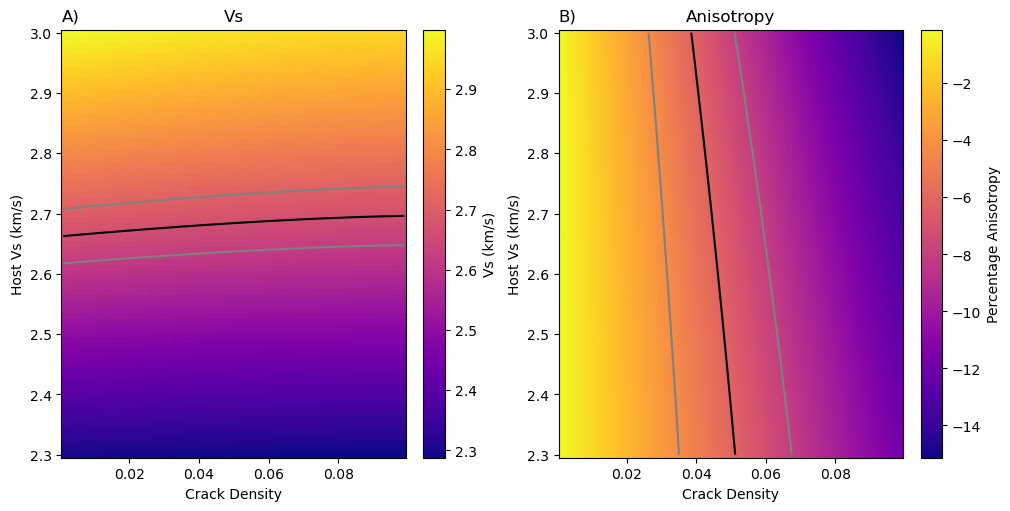

In [197]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),constrained_layout=True)
#
cmap = ax1.pcolormesh(crack_density_range,host_vs_range,vs_grid,cmap=plt.get_cmap("plasma"))
ax1.contour(crack_density_range,host_vs_range,vs_grid,(vs_2km_avg,),colors="black",linestyles="solid")
ax1.contour(crack_density_range,host_vs_range,vs_grid,(vs_2km_avg-vs_2km_std,vs_2km_avg+vs_2km_std),colors=("gray","gray"),linestyles="solid")
ax1.set_xlabel("Crack Density")
ax1.set_ylabel("Host Vs (km/s)")
ax1.set_title("Vs")
ax1.set_title("A)", loc='left')
fig.colorbar(cmap,ax=ax1,label="Vs (km/s)")
# plt.show()
#
# fig, ax = plt.subplots(1, 1)
cmap = ax2.pcolormesh(crack_density_range,host_vs_range,pctani_grid,cmap=plt.get_cmap("plasma"))
ax2.contour(crack_density_range,host_vs_range,pctani_grid,(pctani_2km_avg,),colors="black",linestyles="solid")
ax2.contour(crack_density_range,host_vs_range,pctani_grid,(pctani_2km_avg-pctani_2km_std,pctani_2km_avg+pctani_2km_std),colors=("gray","gray"),linestyles="solid")
ax2.set_xlabel("Crack Density")
ax2.set_ylabel("Host Vs (km/s)")
ax2.set_title("Anisotropy")
ax2.set_title("B)", loc='left')
fig.colorbar(cmap,ax=ax2,label="Percentage Anisotropy")
#
plt.show()

2.681220778530467 0.04840139148602249
0.04515544005400331 0.014295120791570583


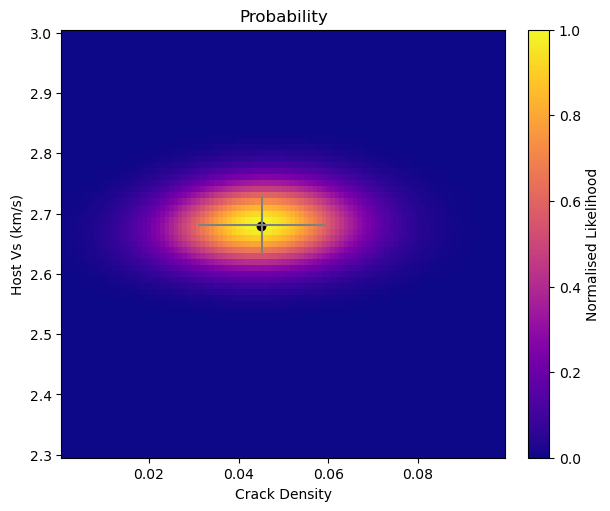

In [198]:
host_vs_marginal = np.sum(probability_grid,axis=1)
crack_density_marginal = np.sum(probability_grid,axis=0)

host_vs_mean = np.average(host_vs_range,weights=host_vs_marginal)
host_vs_std = np.sqrt(np.cov(host_vs_range,aweights=host_vs_marginal))
print(host_vs_mean,host_vs_std)

crack_density_mean = np.average(crack_density_range,weights=crack_density_marginal)
crack_density_std = np.sqrt(np.cov(crack_density_range,aweights=crack_density_marginal))
print(crack_density_mean,crack_density_std)

fig, ax1 = plt.subplots(1,1,figsize=(6,5),constrained_layout=True)
#
cmap = ax1.pcolormesh(crack_density_range,host_vs_range,probability_grid,cmap=plt.get_cmap("plasma"))
ax1.scatter(crack_density_range[inds[1]],host_vs_range[inds[0]],color="black")
ax1.errorbar(crack_density_mean,host_vs_mean,yerr=host_vs_std,xerr=crack_density_std,color="gray")
ax1.set_xlabel("Crack Density")
ax1.set_ylabel("Host Vs (km/s)")
ax1.set_title("Probability")
# ax1.set_title("A)", loc='left')
fig.colorbar(cmap,ax=ax1,label="Normalised Likelihood")
#
plt.show()
if wet:
    fig.savefig("plots/wet_crack_probablity_2km.png")
else:
    fig.savefig("plots/dry_crack_probablity_2km.png")

In [207]:
inds = np.unravel_index(np.argmax(probability_grid, axis=None), probability_grid.shape)
# print(inds)
ml_cd = crack_density_range[inds[1]]
ml_hvs = host_vs_range[inds[0]]
host = anisotropy.materials.isotropic_C(vp=host_vp, vs=ml_hvs, rho=host_rho)
print(ml_cd,ml_hvs)
if wet:
    composite = hudson.model(host,wet_crack,crack_aspect_ratio,ml_cd)
else:
    composite = hudson.model(host,dry_crack,crack_aspect_ratio,ml_cd)
composite = composite.rotate(0,0,90)
print(composite)
print(composite.phase_velocities(0,azimuth=0))

with open("./anisotropic_host_material.txt","w") as f:
    f.write(f"Host Material vp {host_vp:.2f} vs {ml_hvs:.2f}\n")
    f.write(f"Material d={composite.rho/1000:.4f} (g/cm3)\n")
    f.write("  1.0000  1.0000  1.0000 90.0000 90.0000 90.0000\n")
    for i in range(6):
        out = "  "
        for j in range(6):
            number = composite.C[i,j]
            number = number/1000
            out += f"{number: >5.2f} "
        out += "\n"
        f.write(out)

0.045 2.6799999999999917
Material ID - 

C_ijkl =

   38233.231 -2532.491 -3281.041    0.000    0.000    0.000
  -2532.491  30088.316 -2532.491    0.000    0.000    0.000
  -3281.041 -2532.491  38233.231    0.000    0.000   -0.000
     0.000    0.000    0.000  18334.234    0.000    0.000
     0.000    0.000    0.000    0.000  20757.136    0.000
     0.000    0.000   -0.000    0.000    0.000  18334.234

Density (g/cm^3) = 2759.95

Reference

([np.float64(3.7219444975789533)], [np.float64(2.7424145741180403)], [np.float64(2.5773937736738497)], [np.float64(0.0)], array([6.20401299]))


# Crack modeling with depth

In [122]:
depths, average_vs, std_vs, average_pctani, std_pctani = np.loadtxt("askja_depth_average.txt",unpack=True)

wet = False

# x_bar = np.array([vs_2km_avg,pctani_2km_avg])
# C_1 = np.diag([1/vs_2km_std**2,1/pctani_2km_std**2])

host_vs_range = np.arange(2.3,3.0,0.01)
crack_density_range = np.arange(0.001,0.1,0.001)

host_vs_list = []
host_vs_err_list = []
crack_density_list = []
crack_density_err_list = []
for k,depth in enumerate(depths):
    #
    vs_grid = np.zeros((len(host_vs_range),len(crack_density_range)))
    pctani_grid = np.zeros((len(host_vs_range),len(crack_density_range)))
    probability_grid = np.zeros((len(host_vs_range),len(crack_density_range)))
    #
    x_bar = np.array([average_vs[k],average_pctani[k]])
    C_1 = np.diag([1/std_vs[k]**2,1/std_pctani[k]**2])
    #
    for i,host_vs in enumerate(host_vs_range):
        for j,crack_density in enumerate(crack_density_range):
            host = anisotropy.materials.isotropic_C(vp=host_vp, vs=host_vs, rho=host_rho)
            if wet:
                composite = hudson.model(host,wet_crack,crack_aspect_ratio,crack_density)
            else:
                composite = hudson.model(host,dry_crack,crack_aspect_ratio,crack_density)
            pv = composite.phase_velocities(0,azimuth=90)
            vs = (pv[1][0]+pv[2][0])/2
            pctani = 100*(pv[2][0]-pv[1][0])/vs
            #
            vs_grid[i,j] = vs
            pctani_grid[i,j] = pctani
            #
            x = np.array([vs,pctani])
            # print(x)
            diff = x-x_bar
            # print(diff)
            prob = np.dot(np.dot(diff,C_1),diff.T)
            # print(prob)
            prob = np.exp(-0.5*prob)
            # print(prob)
            # raise KeyboardInterrupt
            probability_grid[i,j] = prob
    probability_grid = probability_grid/np.max(probability_grid)
    #
    host_vs_marginal = np.sum(probability_grid,axis=1)
    crack_density_marginal = np.sum(probability_grid,axis=0)
    #
    host_vs_mean = np.average(host_vs_range,weights=host_vs_marginal)
    host_vs_std = np.sqrt(np.cov(host_vs_range,aweights=host_vs_marginal))
    # print(host_vs_mean,host_vs_std)
    #
    crack_density_mean = np.average(crack_density_range,weights=crack_density_marginal)
    crack_density_std = np.sqrt(np.cov(crack_density_range,aweights=crack_density_marginal))
    # print(crack_density_mean,crack_density_std)
    #
    host_vs_list.append(host_vs_mean)
    host_vs_err_list.append(host_vs_std)
    crack_density_list.append(crack_density_mean)
    crack_density_err_list.append(crack_density_std)

host_vs_list = np.array(host_vs_list)
host_vs_err_list = np.array(host_vs_err_list)
crack_density_list = np.array(crack_density_list)
crack_density_err_list = np.array(crack_density_err_list)

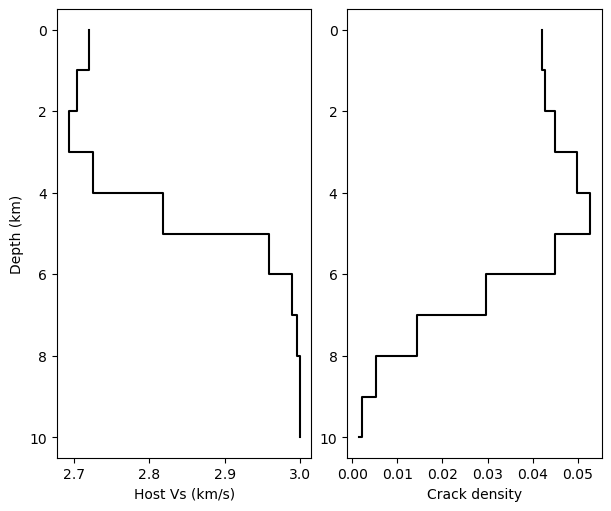

In [128]:
plt_depths = []
plt_vs = []
plt_cd = []
for i in range(len(depths)-1):
    plt_depths.append(depths[i])
    plt_vs.append(host_vs_list[i])
    plt_cd.append(crack_density_list[i])
    plt_depths.append(depths[i+1])
    plt_vs.append(host_vs_list[i])
    plt_cd.append(crack_density_list[i])
plt_depths.append(depths[-1])
plt_vs.append(host_vs_list[-1])
plt_cd.append(crack_density_list[-1])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,5),constrained_layout=True)
#
# ax1.plot(host_vs_list,depths,color="black")
ax1.plot(plt_vs,plt_depths,color="black")
# ax1.plot(host_vs_list-host_vs_err_list,depths,color="gray")
# ax1.plot(host_vs_list+host_vs_err_list,depths,color="gray")
ax1.invert_yaxis()
ax1.set_ylabel("Depth (km)")
ax1.set_xlabel("Host Vs (km/s)")
#
# ax2.plot(crack_density_list,depths,color="black")
ax2.plot(plt_cd,plt_depths,color="black")
# ax2.plot(crack_density_list-crack_density_err_list,depths,color="gray")
# ax2.plot(crack_density_list+crack_density_err_list,depths,color="gray")
ax2.invert_yaxis()
ax2.set_xlabel("Crack density")
#
plt.show()

# Modeling with GassDem

In [151]:
# C = [[97.81, 33.28, 27.62, 0.33, 0.20, -0.11],
#      [33.28, 159.96, 45.85, -0.43, -0.49, -0.66],
#      [27.62, 45.85	 144.48  -0.74  -2.26   -0.42
file = "./Morales2018_ModelSC3_GPa.txt"
C = np.zeros((6,6))
with open(file,"r") as f:
    lines = f.readlines()
    for i,line in enumerate(lines[3:9]):
        line = line.split()
        line = np.array(line,dtype=float)
        C[i,:] = line
# print(C)
morales = anisotropy.materials.core.Material(C*1000,2.7292*1000)
print(morales)
print(morales.phase_velocities(0,azimuth=0))

Material ID - 

C_ijkl =

   97810.000  33280.000  27620.000  330.000  200.000 -110.000
   33280.000  159960.000  45850.000 -430.000 -490.000 -660.000
   27620.000  45850.000  144480.000 -740.000 -2260.000 -420.000
   330.000 -430.000 -740.000  50190.000 -300.000 -550.000
   200.000 -490.000 -2260.000 -300.000  28470.000   70.000
  -110.000 -660.000 -420.000 -550.000   70.000  32180.000

Density (g/cm^3) = 2729.2000000000003

Reference

([np.float64(5.986536526005176)], [np.float64(3.433863978190823)], [np.float64(3.229694853973202)], [np.float64(88.91441494622747)], array([6.12793042]))


In [211]:
host = anisotropy.materials.isotropic_C(vp=3.64, vs=2.7, rho=2890)
# print(host.C)
# print(host.phase_velocities(0,azimuth=0))
with open("./host_material.txt","w") as f:
    f.write("Host Material vp 3.64 vs 2.7\n")
    f.write(f"Material d={host.rho/1000:.4f} (g/cm3)\n")
    f.write("  1.0000  1.0000  1.0000 90.0000 90.0000 90.0000\n")
    for i in range(6):
        out = "  "
        for j in range(6):
            number = host.C[i,j]
            number = number/1000
            out += f"{number: >5.2f} "
        out += "\n"
        f.write(out)
melt = anisotropy.materials.isotropic_C(vp=2.7, vs=0.0, rho=2700)
# print(melt.C)
# print(melt.phase_velocities(0,azimuth=0))
with open("./melt_inclusion_material.txt","w") as f:
    f.write("Host Material vp 2.7 vs 0.0\n")
    f.write(f"Material d={melt.rho/1000:.4f} (g/cm3)\n")
    f.write("  1.0000  1.0000  1.0000 90.0000 90.0000 90.0000\n")
    for i in range(6):
        out = "  "
        for j in range(6):
            number = melt.C[i,j]
            number = number/1000
            out += f"{number: >5.2f} "
        out += "\n"
        f.write(out)

aspect_ratio = 0.5
max_melt_fraction = 0.6

length = 1/aspect_ratio
with open("./other_params.txt","w") as f:
    f.write(f"{host.rho/1000:.4f}\n{melt.rho/1000:.4f}\n")
    f.write(f"{length:.3f}\n")
    f.write(f"{max_melt_fraction}\n")
    f.write(f

### Read output from GassDem

10


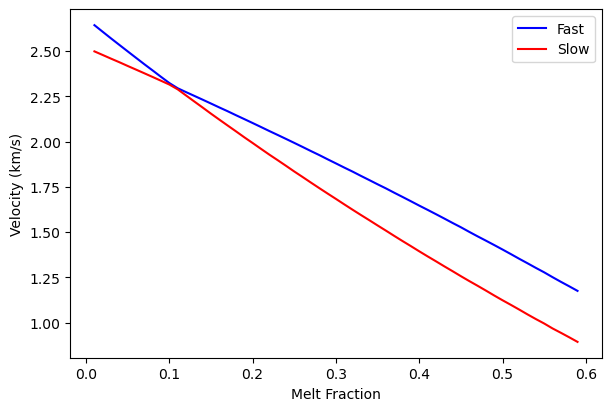

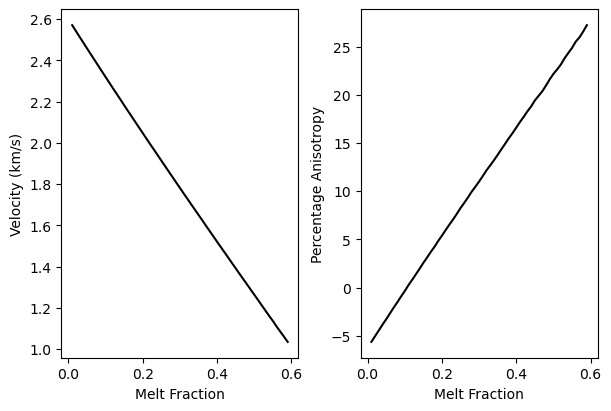

In [223]:
files = glob.glob("outputdir/*-Clow*.txt")
# file = files[0]

outputs = {}
for file in files:
    with open(file,"r") as f:
        C = np.zeros((6,6))
        lines = f.readlines()
        melt_rho_line = lines[1].split("=")
        # print(melt_rho_line)
        melt = float(melt_rho_line[1].split()[0])
        rho = float(melt_rho_line[2].split()[0])
        # print(melt,rho)
        for i,line in enumerate(lines[3:9]):
            line = line.split()
            line = np.array(line,dtype=float)
            C[i,:] = line
        # print(C)
        composite = anisotropy.materials.core.Material(C*1000,rho*1000)
        pv = composite.phase_velocities(0,azimuth=0)
        outputs[melt] = (composite,pv)
        # print("Melt fraction:", melt)
        # print(composite)
        # print(composite.phase_velocities(0,azimuth=90))

# print(outputs)

melt_fraction_range = np.arange(0.01,max_melt_fraction,0.01)
# print(melt_fraction_range)
fast_vs = np.zeros_like(melt_fraction_range)
slow_vs = np.zeros_like(melt_fraction_range)
vs =  np.zeros_like(melt_fraction_range)
pctani = np.zeros_like(melt_fraction_range)
for i,mf in enumerate(melt_fraction_range):
    # print(mf)
    mf = round(mf*100)/100
    composite,pv = outputs[mf]
    fast_vs[i] = pv[1][0]
    slow_vs[i] = pv[2][0]
    # print(mf,pv[1][0],pv[2][0])

same_ind = np.argmin((fast_vs-slow_vs)**2)
print(same_ind)
vs = 0.5*(fast_vs+slow_vs)
pctani[:same_ind] = 100*(slow_vs[:same_ind]-fast_vs[:same_ind])/vs[:same_ind]
pctani[same_ind:] = 100*(fast_vs[same_ind:]-slow_vs[same_ind:])/vs[same_ind:]

fig, ax1 = plt.subplots(1,1,figsize=(6,4),constrained_layout=True)
#
ax1.plot(melt_fraction_range,fast_vs,color="blue",label="Fast")
ax1.plot(melt_fraction_range,slow_vs,color="red",label="Slow")
ax1.set_xlabel("Melt Fraction")
ax1.set_ylabel("Velocity (km/s)")
ax1.legend()
#
plt.show()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,4),constrained_layout=True)
#
ax1.plot(melt_fraction_range,vs,color="black")
ax1.set_xlabel("Melt Fraction")
ax1.set_ylabel("Velocity (km/s)")
#
ax2.plot(melt_fraction_range,pctani,color="black")
ax2.set_xlabel("Melt Fraction")
ax2.set_ylabel("Percentage Anisotropy")
#
plt.show()

## GassDem grid search

In [4]:
# from tqdm import tqdm
# # Define Targets
# target_pctani = 2.426 
# stderr_pctani = 7.572
# target_vs     = 2.487
# stderr_vs     = 0.111
# #
# threads = 4
# #
# host_rho = 2759.9
# melt_rho = 2700
# x_bar = np.array([target_vs,target_pctani])
# C_1 = np.diag([1/stderr_vs**2,1/stderr_pctani**2])
# #
# # Define Search Grid
# max_melt_fraction = 0.6
# melt_fraction_range = np.arange(0.01,max_melt_fraction,0.01)
# aspect_ratio_range = np.arange(0.01,0.95,0.01)
# #
# # Prealocate Search Grids
# pctani_grid = np.zeros((len(melt_fraction_range),len(aspect_ratio_range)))
# vs_grid = np.zeros_like(pctani_grid)
# probability_grid = np.zeros_like(pctani_grid)
# #
# #Begin loop over aspect ratio
# def GassDem_worker(aspect_ratio,k):
#     # Save aspect ratio to other_params.txt
#     length = 1/aspect_ratio
#     with open("./other_params.txt","w") as f:
#         f.write(f"{host_rho/1000:.4f}\n{melt_rho/1000:.4f}\n")
#         f.write(f"{length:.3f}\n")
#         f.write(f"{max_melt_fraction}\n")
#     #
#     # Run GassDem
#     !(matlab -batch "runGassDem" > /dev/null)
#     #
#     # Read output
#     files = glob.glob("outputdir/*-Clow*.txt")
#     outputs = {}
#     for file in files:
#         with open(file,"r") as f:
#             C = np.zeros((6,6))
#             lines = f.readlines()
#             melt_rho_line = lines[1].split("=")
#             # print(melt_rho_line)
#             melt = float(melt_rho_line[1].split()[0])
#             rho = float(melt_rho_line[2].split()[0])
#             # print(melt,rho)
#             for i,line in enumerate(lines[3:9]):
#                 line = line.split()
#                 line = np.array(line,dtype=float)
#                 C[i,:] = line
#             # print(C)
#             composite = anisotropy.materials.core.Material(C*1000,rho*1000)
#             pv = composite.phase_velocities(0,azimuth=0)
#             outputs[melt] = (composite,pv)
#     #
#     fast_vs = np.zeros_like(melt_fraction_range)
#     slow_vs = np.zeros_like(melt_fraction_range)
#     vs_1d =  np.zeros_like(melt_fraction_range)
#     pctani_1d = np.zeros_like(melt_fraction_range)
#     for i,mf in enumerate(melt_fraction_range):
#         mf = round(mf*100)/100
#         composite,pv = outputs[mf]
#         fast_vs[i] = pv[1][0]
#         slow_vs[i] = pv[2][0]
#     same_ind = np.argmin((fast_vs-slow_vs)**2)
#     vs_1d = 0.5*(fast_vs+slow_vs)
#     pctani_1d[:same_ind] = 100*(slow_vs[:same_ind]-fast_vs[:same_ind])/vs_1d[:same_ind]
#     pctani_1d[same_ind:] = 100*(fast_vs[same_ind:]-slow_vs[same_ind:])/vs_1d[same_ind:]
#     #
#     # Calculate probability
#     probability_1d = np.zeros_like(vs_1d)
#     for j,(vs,pctani) in enumerate(zip(vs_1d,pctani_1d)):
#         x = np.array([vs,pctani])
#         diff = x-x_bar
#         prob = np.dot(np.dot(diff,C_1),diff.T)
#         prob = np.exp(-0.5*prob)
#         probability_1d[j] = prob
#     #
#     return k, vs_1d, pctani_1d, probability_1d

# with Pool(threads) as pool:
#     procs = []
#     for k,aspect_ratio in enumerate(aspect_ratio_range):
#         p = pool.apply_async(GassDem_worker,args=(aspect_ratio,k))
#         procs.append(p)
#     for p in tqdm(procs):
#         k, vs_1d, pctani_1d, probability_1d = p.get()
#         pctani_grid[:,k] = pctani_1d
#         vs_grid[:,k] = vs_1d
#         probability_grid[:,k] = probability_1d
# #
# probability_grid = probability_grid/np.max(probability_grid)

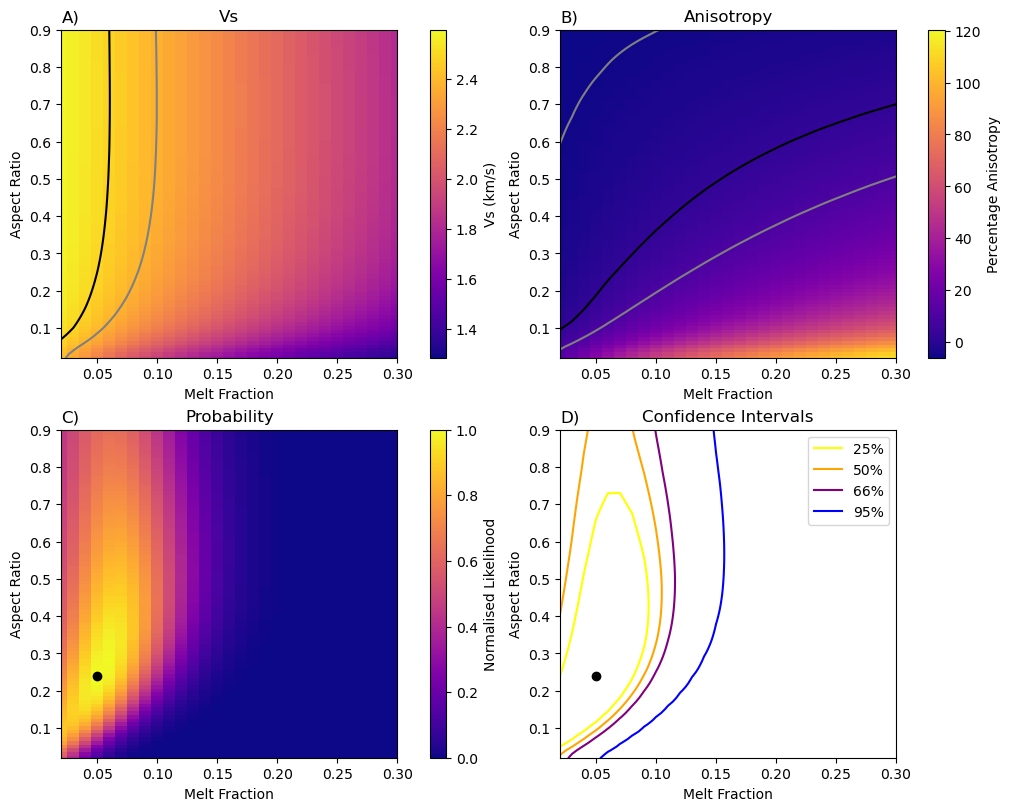

In [40]:
from scipy.ndimage import gaussian_filter
target_pctani = 2.426 
stderr_pctani = 7.572
target_vs     = 2.487
stderr_vs     = 0.111

basedir = "gridsearchoutput"
# basedir = "run1"

sigma = 2
probability_grid = np.load(f"{basedir}/probability_grid.npy")
probability_grid = gaussian_filter(probability_grid,sigma=sigma)
probability_grid = probability_grid/np.max(probability_grid)
pctani_grid = np.load(f"{basedir}/pctani_grid.npy")
pctani_grid = gaussian_filter(pctani_grid,sigma=sigma)
vs_grid = np.load(f"{basedir}/vs_grid.npy")
vs_grid = gaussian_filter(vs_grid,sigma=sigma)

pdf = probability_grid/np.sum(probability_grid)
level_66 = np.max(pdf)
integral = 0
while integral < 0.66 and level_66 > 0:
    integral = np.sum(pdf[np.where(pdf>level_66)])
    level_66 -= 0.0001
level_95 = np.max(pdf)
integral = 0
while integral < 0.95 and level_95 > 0:
    integral = np.sum(pdf[np.where(pdf>level_95)])
    level_95 -= 0.0001
level_50 = np.max(pdf)
integral = 0
while integral < 0.50 and level_50 > 0:
    integral = np.sum(pdf[np.where(pdf>level_50)])
    level_50 -= 0.0001
level_25 = np.max(pdf)
integral = 0
while integral < 0.25 and level_25 > 0:
    integral = np.sum(pdf[np.where(pdf>level_25)])
    level_25 -= 0.0001

melt_fraction_range = np.load(f"{basedir}/melt_fraction_range.npy")
aspect_ratio_range = np.load(f"{basedir}/aspect_ratio_range.npy")

xmin = 0.02
xmax = 0.3
ymin = 0.02
ymax = 0.90

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,8),constrained_layout=True)
#
cmap = ax1.pcolormesh(melt_fraction_range,aspect_ratio_range,vs_grid.T,cmap=plt.get_cmap("plasma"))
ax1.contour(melt_fraction_range,aspect_ratio_range,vs_grid.T,(target_vs,),colors="black",linestyles="solid")
ax1.contour(melt_fraction_range,aspect_ratio_range,vs_grid.T,(target_vs-stderr_vs,target_vs+stderr_vs),colors=("gray","gray"),linestyles="solid")
ax1.set_xlabel("Melt Fraction")
ax1.set_ylabel("Aspect Ratio")
ax1.set_title("Vs")
ax1.set_title("A)", loc='left')
ax1.set_xlim(xmin=xmin,xmax=xmax)
ax1.set_ylim(ymin=ymin,ymax=ymax)
fig.colorbar(cmap,ax=ax1,label="Vs (km/s)")
# plt.show()
#
# fig, ax = plt.subplots(1, 1)
cmap = ax2.pcolormesh(melt_fraction_range,aspect_ratio_range,pctani_grid.T,cmap=plt.get_cmap("plasma"))
ax2.contour(melt_fraction_range,aspect_ratio_range,pctani_grid.T,(target_pctani,),colors="black",linestyles="solid")
ax2.contour(melt_fraction_range,aspect_ratio_range,pctani_grid.T,(target_pctani-stderr_pctani,target_pctani+stderr_pctani),colors=("gray","gray"),linestyles="solid")
ax2.set_xlabel("Melt Fraction")
ax2.set_ylabel("Aspect Ratio")
ax2.set_title("Anisotropy")
ax2.set_title("B)", loc='left')
ax2.set_xlim(xmin=xmin,xmax=xmax)
ax2.set_ylim(ymin=ymin,ymax=ymax)
fig.colorbar(cmap,ax=ax2,label="Percentage Anisotropy")
#
inds = np.unravel_index(np.argmax(probability_grid, axis=None), probability_grid.shape)
#
cmap = ax3.pcolormesh(melt_fraction_range,aspect_ratio_range,probability_grid.T,cmap=plt.get_cmap("plasma"))
ax3.scatter(melt_fraction_range[inds[0]],aspect_ratio_range[inds[1]],color="black")
# ax1.errorbar(crack_density_mean,host_vs_mean,yerr=host_vs_std,xerr=crack_density_std,color="gray")
ax3.set_xlabel("Melt Fraction")
ax3.set_ylabel("Aspect Ratio")
ax3.set_title("Probability")
# ax3.set_xlim(xmax=0.3)
ax3.set_title("C)", loc='left')
ax3.set_xlim(xmin=xmin,xmax=xmax)
ax3.set_ylim(ymin=ymin,ymax=ymax)
fig.colorbar(cmap,ax=ax3,label="Normalised Likelihood")
#
ax4.contour(melt_fraction_range,aspect_ratio_range,pdf.T,(level_25,),colors="yellow",linestyles="solid")
ax4.plot([100],[100],color="yellow",label="25%")
#
ax4.contour(melt_fraction_range,aspect_ratio_range,pdf.T,(level_50,),colors="orange",linestyles="solid")
ax4.plot([100],[100],color="orange",label="50%")
#
ax4.contour(melt_fraction_range,aspect_ratio_range,pdf.T,(level_66,),colors="purple",linestyles="solid")
ax4.plot([100],[100],color="purple",label="66%")
#
ax4.contour(melt_fraction_range,aspect_ratio_range,pdf.T,(level_95,),colors="blue",linestyles="solid")
ax4.plot([100],[100],color="blue",label="95%")
#
ax4.scatter(melt_fraction_range[inds[0]],aspect_ratio_range[inds[1]],color="black")
ax4.set_xlabel("Melt Fraction")
ax4.set_ylabel("Aspect Ratio")
ax4.set_title("Confidence Intervals")
# ax3.set_xlim(xmax=0.3)
ax4.set_title("D)", loc='left')
ax4.set_xlim(xmin=xmin,xmax=xmax)
ax4.set_ylim(ymin=ymin,ymax=ymax)
ax4.legend()
#
plt.show()